# Explore pyiron-like workflows

Aim: Explore how close the presently available features of the pyiron_workflow class allow us to write pyiron-like workflows

In [11]:
%config IPCompleter.evaluation='unsafe'

import matplotlib.pylab as plt
from pyiron_workflow.workflow import Workflow

In [12]:
import warnings
warnings.filterwarnings('ignore')

### Create structure and list available potentials

In [7]:
wf = Workflow('Lammps')
structure = wf.create.atomistics.Bulk('Al', cubic=True)
repeat = wf.create.lammps.Repeat(structure = structure, repeat_scalar=1)
strain = wf.create.lammps.ApplyStrain(structure=repeat, strain=0.0)

strain.pull()

Al: [0. 0. 0.]
Al: [0.    2.025 2.025]
Al: [2.025 0.    2.025]
Al: [2.025 2.025 0.   ]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([4.05, 4.05, 4.05])

In [ ]:
structure.inputs.name = 'Fe'
# structure.inputs.cubic = False
wf.run();

In [ ]:
wf.repeat.plot3d()

In [ ]:
wf.draw(depth=2)

In [ ]:
wf = Workflow('Lammps')
structure = wf.create.atomistics.Bulk('Al', cubic=True)
repeat = wf.create.lammps.Repeat(structure = structure, repeat_scalar=3)
list_potentials = wf.create.lammps.ListPotentials(structure=repeat)    
wf.run()
list_potentials.outputs.potentials.value[:5]

In [9]:
wf = Workflow('Lammps')
structure = wf.create.atomistics.Bulk('Al', cubic=True)
repeat = wf.create.lammps.Repeat(structure = structure, repeat_scalar=3)
list_potentials = wf.create.lammps.ListPotentials(structure=repeat)    
#wf.run()
#list_potentials.outputs.potentials.value[:5]

In [10]:
repeat

NotData

In [ ]:
wf = Workflow('Lammps')
structure = wf.create.atomistics.Bulk('Al', cubic=True)
repeat = wf.create.lammps.Repeat(structure = structure, repeat_scalar=3)

lammps = wf.create.atomistic_codes.Lammps(structure=repeat, label='lammps')
wf.run()

### MD over list of temperatures

In [ ]:
%%time
for T in [300, 600, 900]:
    wf = Workflow('Lammps')
    structure = wf.create.atomistics.Bulk('Al', cubic=True)
    repeat = wf.create.lammps.Repeat(structure = structure, repeat_scalar=3)
    
    lammps = wf.create.atomistic_codes.Lammps(structure=repeat, label='lammps')
    lammps.calc_select.md(temperature=T, n_ionic_steps=10_000)
    
    wf.run()
    
    plt.plot(wf.lammps.outputs.generic.value.energy_pot[2:], label=f'T={T}K')
plt.legend();    

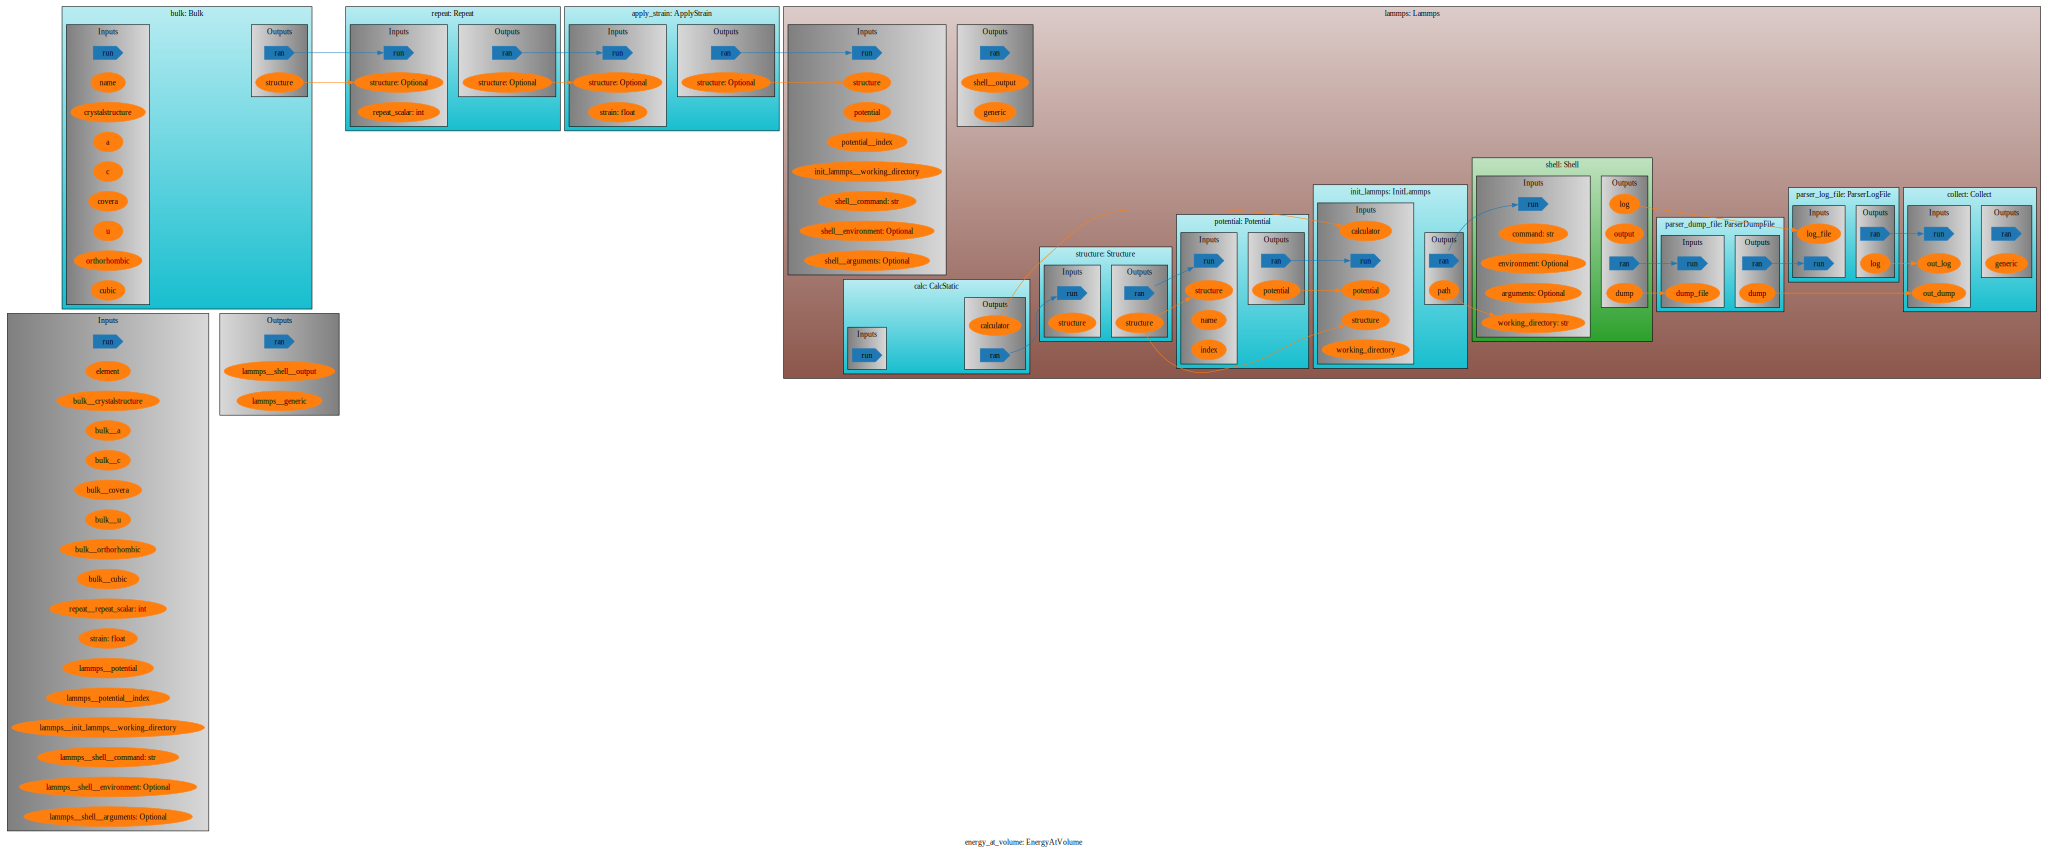

In [16]:
wf.draw(depth=2)

In [ ]:
wf.lammps.draw()

### Murnaghan (E-V) macro

In [ ]:
# volumes = wf.create.standard.Linspace(0.9, 1.1, 11)

In [13]:
@Workflow.wrap_as.macro_node()
def energy_at_volume(wf) -> None:
    bulk = wf.create.atomistics.Bulk('Al', cubic=True)
    repeat = wf.create.lammps.Repeat(structure = bulk, repeat_scalar=1)
    apply_strain = wf.create.lammps.ApplyStrain(structure=repeat, strain=1)
    
    
    lammps = wf.create.atomistic_codes.Lammps(structure=apply_strain, label='lammps')
    
    wf.inputs_map = {
        "bulk__name": "element",
        "apply_strain__strain": "strain",
        "lammps__potential__name": "potential",
    }
    wf.outputs_map = {"lammps__collect__generic": "generic"}

In [ ]:
wf.create.iter(energy_at_volume, strain=wf.create.numpy.linspace(-0.2, 0.2, 11))

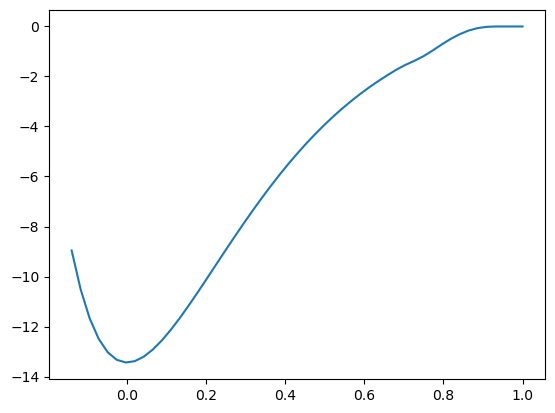

In [14]:
import numpy as np

energy_pot = []
strain_lst = np.linspace(0.86, 2, 51) - 1
for strain in strain_lst:
    wf = energy_at_volume(element='Al', strain=strain)
    out = wf.run()

    energy_pot.append(out['lammps__generic'].energy_pot.iloc[0])  

plt.plot(strain_lst, energy_pot);